<a href="https://colab.research.google.com/github/tasyapandya/stockPrediction-LSTM/blob/main/Model_Prediction_One_Stock_v2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [25]:
!pip install ta
!pip install tensorflow keras-tuner
!pip install yfinance --upgrade --no-cache-dir

In [26]:
import yfinance as yf
import ta
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras_tuner import BayesianOptimization
from tensorflow.keras.metrics import RootMeanSquaredError
# from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import os

# 1. Data Collecting

In [161]:
"""
    format code awal untuk multistock/index, jadi beberapa line code bakal keliatan agak aneh dan kurang efektif
    will do improve code writing later
"""

target_tickers = ['AAPL']
start_date = '2017-01-01'
end_date = '2025-03-01'

target_cols = ['Close_AAPL']
window = 20

In [162]:
def get_stock_data(tickers, start_date, end_date):
    """
    Download dan siapin data saham dari ticker yang dimasukin (contoh: AAPL)
    Hasil akhirnya berupa DataFrame dengan nama kolom yang udah dirapihin.
    """
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)

    if data.empty:
        print("No data found. Check your tickers and date range.")
        return pd.DataFrame()

    # Ambil data hanya di hari kerja
    all_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    data = data.reindex(all_dates)

    # Isi data yang kosong ke depan (forward fill), biar ga ada NaN
    data = data.ffill()

    # Flatten MultiIndex (ga kepake, fokus cuma di AAPL)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [f"{ticker}_{field}" for field, ticker in data.columns]
    else:
        data.columns = [f"AAPL_{col}" for col in data.columns]  # fallback, just in case

    print(f"\nDownloaded data shape: {data.shape}")
    return data


In [163]:

def clean_data(df, target_tickers):

    # Ganti nilai inf/-inf jadi NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Track initial data size
    initial_rows = len(df)
    print(f"\nInitial data shape: {df.shape}")

    # 1. Forward-fill hanya raw price/volume kolom untuk AAPL
    for ticker in target_tickers:
        raw_cols = [f'{ticker}_Close', f'{ticker}_High',  # Format: Ticker_Field
                   f'{ticker}_Low', f'{ticker}_Open', f'{ticker}_Volume']
        if set(raw_cols).issubset(df.columns):
            df[raw_cols] = df[raw_cols].ffill()

    # 2. Technical indicators untuk AAPL
    for ticker in target_tickers:
        print(f"\nProcessing {ticker}...")

        # Base columns (format Ticker_Field)
        close_col = f'{ticker}_Close'
        high_col = f'{ticker}_High'
        low_col = f'{ticker}_Low'
        volume_col = f'{ticker}_Volume'

        # Skip jika base columns tidak ada
        if close_col not in df.columns:
            print(f"Missing base columns untuk {ticker}")
            continue

        # Price changes
        for period in [1, 5, 15]:
            df[f'{ticker}_Price_{period}d_Change'] = df[close_col].pct_change(periods=period, fill_method=None)

        # RSI
        df[f'{ticker}_RSI'] = ta.momentum.rsi(df[close_col])

        # MACD
        macd = ta.trend.MACD(df[close_col])
        df[f'{ticker}_MACD'] = macd.macd()
        df[f'{ticker}_MACD_Signal'] = macd.macd_signal()
        df[f'{ticker}_MACD_Hist'] = macd.macd_diff()

        # Volume indicators
        df[f'{ticker}_Volume_Change'] = df[volume_col].pct_change(fill_method=None)
        df[f'{ticker}_OBV'] = ta.volume.OnBalanceVolumeIndicator(df[close_col], df[volume_col]).on_balance_volume()

        # Volatility indicators
        df[f'{ticker}_ATR'] = ta.volatility.AverageTrueRange(df[high_col], df[low_col], df[close_col]).average_true_range()
        df[f'{ticker}_ATR_Pct'] = df[f'{ticker}_ATR'] / df[close_col]

        # Moving averages
        for window in [10, 20, 50]:
            df[f'{ticker}_SMA_{window}'] = ta.trend.SMAIndicator(df[close_col], window=window).sma_indicator()

        df[f'{ticker}_EMA_20'] = ta.trend.ema_indicator(df[close_col], window=20)

        # Price relative to SMA
        df[f'{ticker}_Price_to_SMA20'] = df[close_col] / df[f'{ticker}_SMA_20'] - 1
        df[f'{ticker}_Price_to_SMA50'] = df[close_col] / df[f'{ticker}_SMA_50'] - 1

        # Stochastic Oscillator
        df[f'{ticker}_Stoch_K'] = ta.momentum.stoch(df[high_col], df[low_col], df[close_col])
        df[f'{ticker}_Stoch_D'] = ta.momentum.stoch_signal(df[high_col], df[low_col], df[close_col])

        # Donchian Channel
        df[f'{ticker}_Donchian_High'] = df[high_col].rolling(20).max()
        df[f'{ticker}_Donchian_Low'] = df[low_col].rolling(20).min()

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(df[close_col])
        df[f'{ticker}_BB_Width'] = bb.bollinger_wband()

        # Feature interaction
        df[f'{ticker}_Volatility_Volume'] = df[f'{ticker}_ATR'] * df[volume_col]
        df[f'{ticker}_RSI_PriceRatio'] = df[f'{ticker}_RSI'] / df[close_col]

        # Bull Market
        df[f'{ticker}_Bull_Market'] = (df[close_col].rolling(50).mean() > df[close_col].rolling(200).mean()).astype(int)

        # Relative Volume
        df[f'{ticker}_RVOL_10'] = df[volume_col] / df[volume_col].rolling(10).mean()

    # 3. lagged features (versi mundur dari fitur utama)
    lagged_features = {}
    lags = [1, 2, 3]
    for ticker in target_tickers:
        for feat in ['Price_1d_Change', 'RSI', 'MACD', 'ATR', 'SMA_20']:
            col = f'{ticker}_{feat}'  # Format: Ticker_Feature
            if col in df.columns:
                for lag in lags:
                    lagged_features[f'{col}_lag{lag}'] = df[col].shift(lag)

    df = pd.concat([df, pd.DataFrame(lagged_features, index=df.index)], axis=1)

   # 4. Final Cleaning bersihin NaN di kolom indikator penting
    tech_indicators = ['RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'SMA_50', 'Price_to_SMA50']
    critical_cols = [f"{ticker}_{ind}" for ticker in target_tickers for ind in tech_indicators]
    df = df.dropna(subset=critical_cols)

    # Reporting
    final_rows = len(df)
    print(f"\nCleaning Report:")
    print(f"- Rows removed: {initial_rows - final_rows}")
    print(f"- Final data shape: {df.shape}")
    print(f"- Remaining NaN: {df.isna().sum().sum()}")

    return df


In [164]:
# Cek data yang terdownload
raw_data = get_stock_data(target_tickers, start_date, end_date)
print("\nContoh data:")
print(raw_data.head())

# Proses cleaning
processed_data = clean_data(raw_data, target_tickers)
print("\nColumns after cleaning:")
print(processed_data.columns.tolist())



Downloaded data shape: (2130, 5)

Contoh data:
            AAPL_Close  AAPL_High   AAPL_Low  AAPL_Open  AAPL_Volume
2017-01-02         NaN        NaN        NaN        NaN          NaN
2017-01-03   26.827244  26.868819  26.506195  26.746404  115127600.0
2017-01-04   26.797220  26.910397  26.734859  26.757956   84472400.0
2017-01-05   26.933496  26.991239  26.748719  26.774126   88774400.0
2017-01-06   27.233751  27.291494  26.901153  26.972753  127007600.0

Initial data shape: (2130, 5)

Processing AAPL...

Cleaning Report:
- Rows removed: 50
- Final data shape: (2080, 46)
- Remaining NaN: 0

Columns after cleaning:
['AAPL_Close', 'AAPL_High', 'AAPL_Low', 'AAPL_Open', 'AAPL_Volume', 'AAPL_Price_1d_Change', 'AAPL_Price_5d_Change', 'AAPL_Price_15d_Change', 'AAPL_RSI', 'AAPL_MACD', 'AAPL_MACD_Signal', 'AAPL_MACD_Hist', 'AAPL_Volume_Change', 'AAPL_OBV', 'AAPL_ATR', 'AAPL_ATR_Pct', 'AAPL_SMA_10', 'AAPL_SMA_20', 'AAPL_SMA_50', 'AAPL_EMA_20', 'AAPL_Price_to_SMA20', 'AAPL_Price_to_SMA50', 'AA

<ipython-input-162-2833517110>:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, progress=False)


# 2. EDA


Processing data for AAPL...


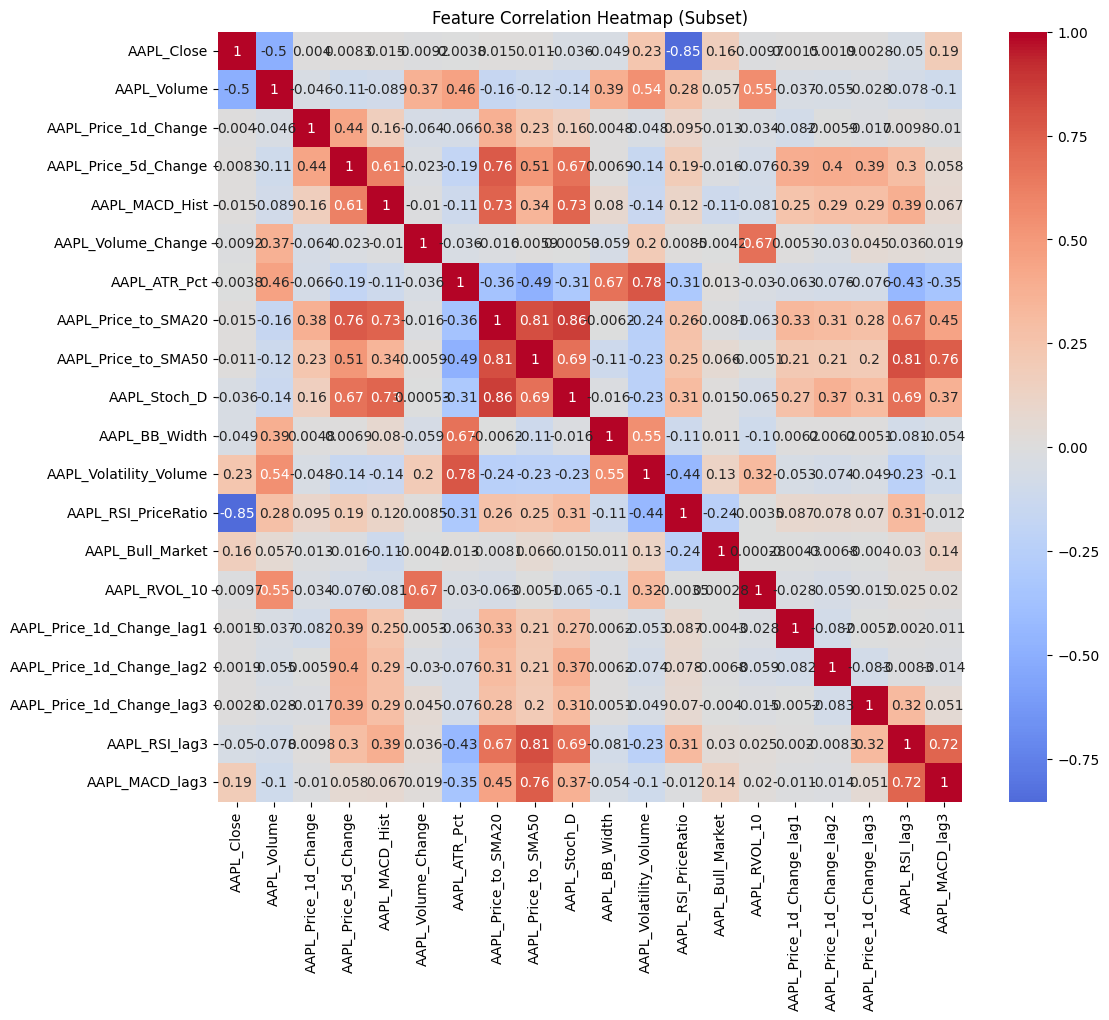

In [165]:

# Define global rules (ambil yg relevan)
global_rules = {
    'always_keep': ['Close', 'Volume'],
    'drop_if_corr': ['High', 'Low', 'Open'],  # Drop if correlation > 0.9 with Close
    'tech_indicators': ['RSI', 'MACD', 'ATR']
}

# Define ticker
tickers = ['AAPL']  # bs buat adjust kalau mau jadi multi index

# Initialize a list untuk track features untuk di drop
features_to_drop = []

# Process for each ticker (untuk permudah saat proses scale up multistock)
for ticker in tickers:
    print(f"\nProcessing data for {ticker}...")

    # Calculate matrix correlation per ticker
    corr_matrix = processed_data.filter(regex=ticker).corr()

    # Identifiy high correlation pairs (>0.9) untuk redundancy check
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.9:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    # Dari pasangan fitur yang berkorelasi tinggi, pilih satu untuk dihapus
    for pair in high_corr_pairs:
        if "Close" in pair[0]:  # Prefer to keep 'Close'
            features_to_drop.append(pair[1])
        else:
            features_to_drop.append(pair[0])

    # Remove duplicates dari daftar fitur yang akan dihapus
    features_to_drop = list(set(features_to_drop))

    # Remove features berdasarkan global_rule: drop_if_corr
    for feature in global_rules['drop_if_corr']:
        col_name = f"{ticker}_{feature}"
        close_col = f"{ticker}_Close"
        if col_name in corr_matrix.columns and close_col in corr_matrix.columns:
            corr_val = corr_matrix[close_col].corr(corr_matrix[col_name])
            if abs(corr_val) > 0.9:
                features_to_drop.append(col_name)

    # Drop redundant features dari data
    processed_data = processed_data.drop(columns=list(set(features_to_drop)))

# Calculate matrix correlation untuk sisa features
correlation_matrix = processed_data.corr()

# Visualisasi plotting correlation heatmap untuk top 20 features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.iloc[:20, :20], annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (Subset)')
plt.show()


In [166]:
# Ambil daftar fitur sebelum dan sesudah drop
original_features = corr_matrix.columns.tolist()
remaining_features = processed_data.filter(regex=ticker).columns.tolist()
removed_features = list(set(original_features) - set(remaining_features))

# Cetak ringkasan
print(f"\n=== Report Penghapusan Fitur untuk {ticker} ===")
print(f"Total fitur awal        : {len(original_features)}")
print(f"Total fitur setelah drop: {len(remaining_features)}")
print(f"Jumlah fitur dihapus    : {len(removed_features)}\n")

# Tampilkan fitur-fitur yang dihapus
print("Daftar fitur yang dihapus:")
for feat in sorted(removed_features):
    print("-", feat)



=== Report Penghapusan Fitur untuk AAPL ===
Total fitur awal        : 46
Total fitur setelah drop: 21
Jumlah fitur dihapus    : 25

Daftar fitur yang dihapus:
- AAPL_ATR
- AAPL_ATR_lag1
- AAPL_ATR_lag2
- AAPL_Donchian_High
- AAPL_Donchian_Low
- AAPL_EMA_20
- AAPL_High
- AAPL_Low
- AAPL_MACD
- AAPL_MACD_Signal
- AAPL_MACD_lag1
- AAPL_MACD_lag2
- AAPL_OBV
- AAPL_Open
- AAPL_Price_15d_Change
- AAPL_RSI
- AAPL_RSI_lag1
- AAPL_RSI_lag2
- AAPL_SMA_10
- AAPL_SMA_20
- AAPL_SMA_20_lag1
- AAPL_SMA_20_lag2
- AAPL_SMA_20_lag3
- AAPL_SMA_50
- AAPL_Stoch_K


# 3. Prepare Feature

In [167]:
def cap_outliers(df, factor=2.5):
    df_clean = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean[col] = np.clip(df[col], lower, upper)
    return df_clean

In [168]:
def prepare_lstm_data(data, target_tickers, n_steps=10, test_size=0.2):
    # 1. Buat nama kolom target
    target_cols = [f'{ticker}_Close' for ticker in target_tickers]
    assert all(col in data.columns for col in target_cols), "Kolom target tidak ditemukan!"

    # 2. Pisahkan fitur dan target
    features_df = data.drop(columns=target_cols)
    targets_df = data[target_cols]

    feature_names = features_df.columns.tolist()

    features = features_df.values
    targets = targets_df.values

    # 3. Buat sequences
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i - n_steps:i])
        y.append(targets[i])

    X = np.array(X)
    y = np.array(y)

    # 4. Split sebelum scaling
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # 5. Scaling
    feature_scaler = MinMaxScaler().fit(X_train.reshape(-1, X_train.shape[2]))
    target_scaler = RobustScaler().fit(y_train)

    X_train = np.array([feature_scaler.transform(x) for x in X_train])
    X_test = np.array([feature_scaler.transform(x) for x in X_test])
    y_train = target_scaler.transform(y_train)
    y_test = target_scaler.transform(y_test)

    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler, feature_names

In [169]:
from sklearn.linear_model import Ridge

def lstm_feature_importance(X_train, y_train, feature_names, top_n=20):
    """Feature importance khusus untuk data sequential dengan Ridge Regression"""
    # Flatten data sequence
    n_samples, n_timesteps, n_features = X_train.shape
    X_flat = X_train.reshape((n_samples, n_timesteps * n_features))

    # Train model Ridge
    model = Ridge(alpha=1.0)
    model.fit(X_flat, y_train)

    # Hitung importance berdasarkan koefisien absolut
    importance = np.abs(model.coef_)

    # Map ke fitur asli dengan rata-rata per fitur
    feature_importance = {}
    for i in range(n_features):
        # Ambil indeks untuk semua timestep dari fitur ke-i
        idx = [j for j in range(i, n_timesteps*n_features, n_features)]
        # Hitung rata-rata importance untuk fitur ini di semua timestep
        feature_importance[feature_names[i]] = np.mean(importance[idx])

    # 5. Urutkan dan tampilkan
    sorted_importance = sorted(feature_importance.items(),
                              key=lambda x: x[1],
                              reverse=True)[:top_n]
    return dict(sorted_importance)

In [202]:
data_for_training = processed_data.copy()

# Step 1: Siapkan data
X_train, X_test, y_train, y_test, feature_scaler, target_scaler, feature_names = prepare_lstm_data(
    data_for_training,
    target_tickers=['AAPL']
)

# Step 2: Hitung importance
importance = lstm_feature_importance(X_train, y_train, feature_names)

# Step 3: Tampilkan
for feat, imp in importance.items():
    print(f"{feat}: {imp:.4f}")

# Step 4: Seleksi fitur
threshold = 0.01
selected_features = [feat for feat, imp in importance.items() if imp > threshold]
print("Fitur terseleksi:", selected_features)

# Step 5: Simpan
# Ubah dictionary ke list of tuples
importance_items = list(importance.items())
joblib.dump(importance_items, 'feature_importance.save')
feature_names = joblib.load('feature_names.save')
features = processed_data[feature_names].values
print("features head:", features[:2])

joblib.dump(feature_scaler, 'feature_scaler.save')
joblib.dump(target_scaler, 'target_scaler.save')

# Step 6 (optional): Filter dataset dengan fitur terseleksi
processed_data = processed_data[selected_features + ['AAPL_Close']]  # Jangan lupa tambahkan target buat training ulang

# 6. Prepare ulang data setelah filter fitur
X_train, X_test, y_train, y_test, feature_scaler, target_scaler, feature_names = prepare_lstm_data(
    processed_data, target_tickers=['AAPL']
)

AAPL_Price_to_SMA50: 0.1730
AAPL_ATR_Pct: 0.1657
AAPL_ATR_lag3: 0.1330
AAPL_RSI_PriceRatio: 0.1169
AAPL_MACD_lag3: 0.0975
AAPL_RSI_lag3: 0.0815
AAPL_MACD_Hist: 0.0769
AAPL_Volatility_Volume: 0.0503
AAPL_Volume: 0.0501
AAPL_Volume_Change: 0.0454
AAPL_Price_to_SMA20: 0.0345
AAPL_Price_5d_Change: 0.0217
AAPL_RVOL_10: 0.0194
AAPL_Stoch_D: 0.0156
AAPL_Price_1d_Change: 0.0150
AAPL_Price_1d_Change_lag2: 0.0114
AAPL_Price_1d_Change_lag1: 0.0113
AAPL_Price_1d_Change_lag3: 0.0108
AAPL_Bull_Market: 0.0103
Fitur terseleksi: ['AAPL_Price_to_SMA50', 'AAPL_ATR_Pct', 'AAPL_ATR_lag3', 'AAPL_RSI_PriceRatio', 'AAPL_MACD_lag3', 'AAPL_RSI_lag3', 'AAPL_MACD_Hist', 'AAPL_Volatility_Volume', 'AAPL_Volume', 'AAPL_Volume_Change', 'AAPL_Price_to_SMA20', 'AAPL_Price_5d_Change', 'AAPL_RVOL_10', 'AAPL_Stoch_D', 'AAPL_Price_1d_Change', 'AAPL_Price_1d_Change_lag2', 'AAPL_Price_1d_Change_lag1', 'AAPL_Price_1d_Change_lag3', 'AAPL_Bull_Market']
features head: [[ 8.31109816e-02  9.36318258e-03  3.16362186e-01  2.36187211

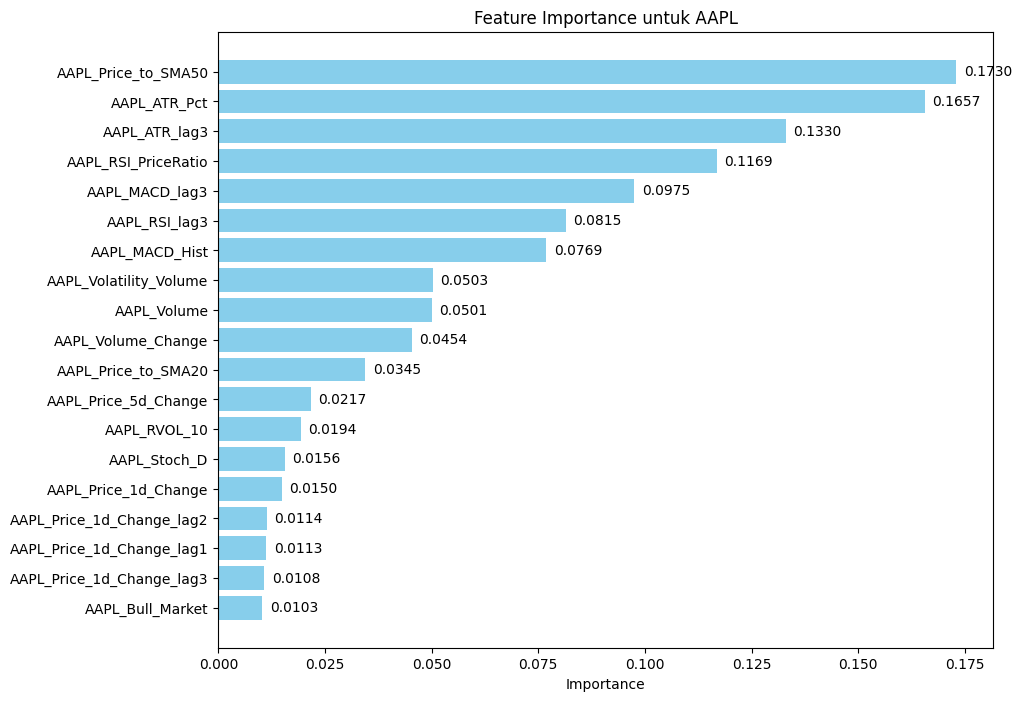

In [181]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(feature_importance_dict, title="Feature Importance untuk AAPL", top_n=20):
    # Sort fitur berdasarkan importance
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    features, importances = zip(*sorted_features)

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(features))
    plt.barh(y_pos, importances, align='center', color='skyblue')
    plt.yticks(y_pos, features)
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.xlabel('Importance')
    plt.title(title)

    # Add nilai importance di samping bar
    for i, v in enumerate(importances):
        plt.text(v + max(importances)*0.01, i, f'{v:.4f}', va='center')

    plt.show()

filtered_importance = {feat: imp for feat, imp in importance.items() if feat in selected_features}
plot_feature_importance(filtered_importance)


# Modelling

In [182]:
def build_model(hp):
    model = Sequential()
    units1 = hp.Int('units_layer1', 128, 512, step=64)
    units2 = hp.Int('units_layer2', 64, 256, step=64)
    dropout1 = hp.Float('dropout1', 0.3, 0.6, step=0.1)
    dropout2 = hp.Float('dropout2', 0.2, 0.5, step=0.1)
    dense_units = hp.Int('dense_units', 32, 128, step=32)
    use_bidi = hp.Boolean('use_bidirectional')

    # Layer pertama (BiLSTM)
    if use_bidi:
        model.add(Bidirectional(LSTM(units1, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(LSTM(units1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout1))

    # Layer kedua (LSTM)
    model.add(LSTM(units2))
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(target_tickers)))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-4, 5e-4, 1e-3])),
        loss='huber',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

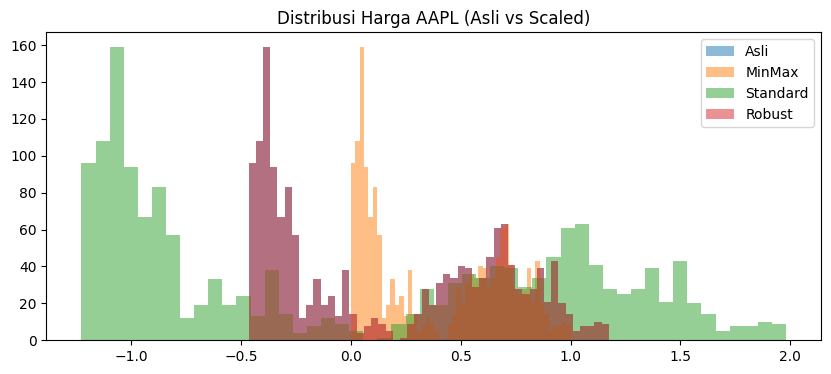

In [183]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# y_train asli (harga AAPL)
plt.figure(figsize=(10,4))
plt.hist(y_train, bins=50, alpha=0.5, label='Asli')
plt.hist(MinMaxScaler().fit_transform(y_train), bins=50, alpha=0.5, label='MinMax')
plt.hist(StandardScaler().fit_transform(y_train), bins=50, alpha=0.5, label='Standard')
plt.hist(RobustScaler().fit_transform(y_train), bins=50, alpha=0.5, label='Robust')
plt.legend()
plt.title('Distribusi Harga AAPL (Asli vs Scaled)')
plt.show()


In [184]:
from tensorflow.keras import Input
from keras_tuner.engine.hyperparameters import HyperParameters

# hyperparameter fix untuk debugging
hp = HyperParameters()
hp.Fixed('units', 128)
hp.Fixed('num_layers', 2)
hp.Fixed('dropout', 0.3)
hp.Fixed('lr', 0.001)

model = build_model(hp)

model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,425 (497.75 KB)

 Trainable params: 127,361 (497.50 KB)

 Non-trainable params: 64 (256.00 B)

In [185]:
def report_data_sizes(raw_data, processed_data, n_steps=10, test_size=0.2):
    # Data awal
    data_awal_len = len(raw_data)

    # Setelah dropna
    data_dropna_len = len(processed_data)

    # Deteksi kolom target
    target_cols = [col for col in processed_data.columns if '_Close' in col]

    # Buat sequence dari processed_data
    features = processed_data.drop(columns=target_cols).values
    targets = processed_data[target_cols].values

    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i])
        y.append(targets[i])
    X = np.array(X)
    y = np.array(y)

    # Split train-test
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return {
        "Data awal": data_awal_len,
        "Setelah dropna": data_dropna_len,
        "Setelah sequence": X.shape[0],
        "Train": X_train.shape[0],
        "Test": X_test.shape[0]
    }

# Contoh pemanggilan:
report = report_data_sizes(raw_data, processed_data, n_steps=10, test_size=0.2)
for k, v in report.items():
    print(f"{k}: {v}")


Data awal: 2130
Setelah dropna: 2080
Setelah sequence: 2070
Train: 1656
Test: 414


In [186]:
print(f"X_train shape: {X_train.shape}")  # Harus (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # Harus (samples, num_targets)

print("Selected features:", selected_features)
print("Jumlah selected features:", len(selected_features))


X_train shape: (1656, 10, 19)
y_train shape: (1656, 1)
Selected features: ['AAPL_Price_to_SMA50', 'AAPL_ATR_Pct', 'AAPL_ATR_lag3', 'AAPL_RSI_PriceRatio', 'AAPL_MACD_lag3', 'AAPL_RSI_lag3', 'AAPL_MACD_Hist', 'AAPL_Volatility_Volume', 'AAPL_Volume', 'AAPL_Volume_Change', 'AAPL_Price_to_SMA20', 'AAPL_Price_5d_Change', 'AAPL_RVOL_10', 'AAPL_Stoch_D', 'AAPL_Price_1d_Change', 'AAPL_Price_1d_Change_lag2', 'AAPL_Price_1d_Change_lag1', 'AAPL_Price_1d_Change_lag3', 'AAPL_Bull_Market']
Jumlah selected features: 19


In [187]:
print("Kolom di processed_data:", processed_data.columns.tolist())
print("Jumlah kolom:", len(processed_data.columns))


Kolom di processed_data: ['AAPL_Price_to_SMA50', 'AAPL_ATR_Pct', 'AAPL_ATR_lag3', 'AAPL_RSI_PriceRatio', 'AAPL_MACD_lag3', 'AAPL_RSI_lag3', 'AAPL_MACD_Hist', 'AAPL_Volatility_Volume', 'AAPL_Volume', 'AAPL_Volume_Change', 'AAPL_Price_to_SMA20', 'AAPL_Price_5d_Change', 'AAPL_RVOL_10', 'AAPL_Stoch_D', 'AAPL_Price_1d_Change', 'AAPL_Price_1d_Change_lag2', 'AAPL_Price_1d_Change_lag1', 'AAPL_Price_1d_Change_lag3', 'AAPL_Bull_Market', 'AAPL_Close']
Jumlah kolom: 20


In [188]:
baseline_mape = np.mean(np.abs((y_test[1:] - y_test[:-1])/y_test[1:])) * 100
print(f"Baseline MAPE: {baseline_mape:.2f}%")

Baseline MAPE: 1.67%


In [189]:
from keras_tuner import Objective

# Initialize tuner dengan metode Bayesian Optimization
tuner = BayesianOptimization(
    build_model,
    objective=Objective("val_rmse", direction="min"),
    max_trials=40,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='one_stock'
)

# Callback untuk stop training lebih awal jika performa tidak meningkat
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',
    mode='min',
    patience=10,
    restore_best_weights=True
)

# Callback untuk mengatur ulang learning rate saat model stagnan
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_rmse',
    factor=0.5,
    patience=5,
    mode='min'
)

# Callback untuk menyimpan model terbaik ke file
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_rmse',
    save_best_only=True,
    mode='min'
)

tuner.search(
    X_train,
    y_train,
    epochs=200,
    batch_size=hp.Int('batch_size', 32, 128, step=32),
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

Trial 40 Complete [00h 04m 19s]
val_rmse: 0.0748104453086853

Best val_rmse So Far: 0.059239719063043594
Total elapsed time: 01h 22m 59s


In [191]:
tuner.results_summary()

Results summary
Results in lstm_tuning/one_stock
Showing 10 best trials
Objective(name="val_rmse", direction="min")

Trial 11 summary
Hyperparameters:
units_layer1: 448
units_layer2: 256
dropout1: 0.3
dropout2: 0.30000000000000004
dense_units: 64
use_bidirectional: False
lr: 0.001
Score: 0.059239719063043594

Trial 26 summary
Hyperparameters:
units_layer1: 512
units_layer2: 64
dropout1: 0.3
dropout2: 0.2
dense_units: 96
use_bidirectional: False
lr: 0.001
Score: 0.06315784901380539

Trial 13 summary
Hyperparameters:
units_layer1: 256
units_layer2: 192
dropout1: 0.3
dropout2: 0.2
dense_units: 64
use_bidirectional: False
lr: 0.001
Score: 0.06433306634426117

Trial 07 summary
Hyperparameters:
units_layer1: 448
units_layer2: 192
dropout1: 0.4
dropout2: 0.30000000000000004
dense_units: 96
use_bidirectional: False
lr: 0.001
Score: 0.06756085157394409

Trial 36 summary
Hyperparameters:
units_layer1: 384
units_layer2: 64
dropout1: 0.3
dropout2: 0.30000000000000004
dense_units: 32
use_bidirectio

In [197]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [204]:
best_model = model.save('best_model.keras')

In [198]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

In [199]:
# Prediksi
y_pred_scaled = best_model.predict(X_test)

# Balikin ke skala asli
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

# Evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

def mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_score = mape(y_test_original, y_pred)

print(f"MAPE: {mape_score:.2f}%")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
MAPE: 5.17%
RMSE: 13.8723
MAE: 11.0952
R²: 0.7208


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


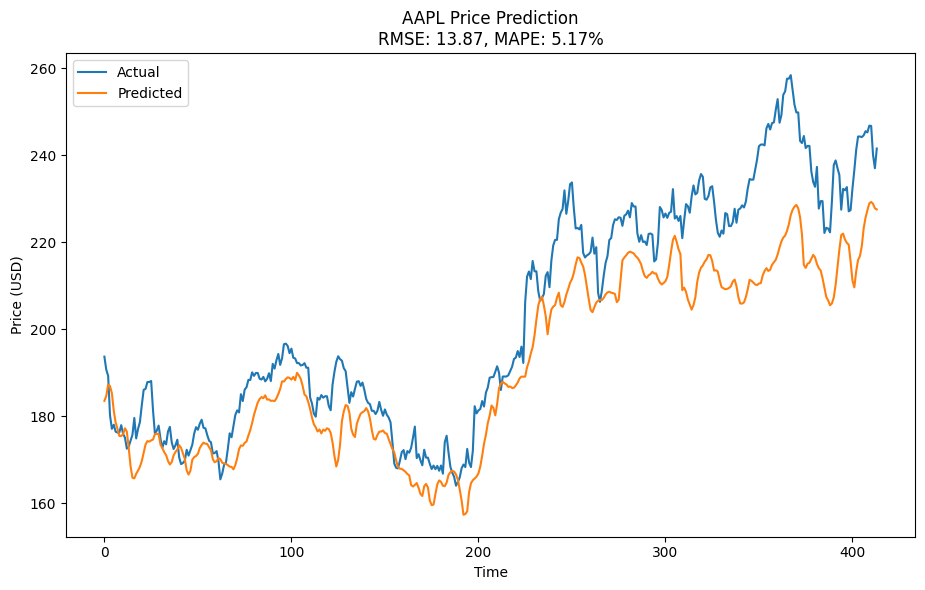

In [195]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Prediksi dan inverse transform
predictions = best_model.predict(X_test)
predictions_3d = predictions.reshape(-1, len(target_tickers))
y_test_3d = y_test.reshape(-1, len(target_tickers))

predicted_prices = target_scaler.inverse_transform(predictions_3d)
actual_prices = target_scaler.inverse_transform(y_test_3d)

# Hitung metrics & plotting
plt.figure(figsize=(18, 6 * len(target_tickers)))

for i, ticker in enumerate(target_tickers):
    # Hitung metrik
    actual = actual_prices[:, i]
    predicted = predicted_prices[:, i]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    error = actual - predicted

    # Subplot harga
    plt.subplot(len(target_tickers), 2, 2 * i + 1)
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f'{ticker} Price Prediction\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%')
    plt.ylabel('Price (USD)')
    plt.xlabel('Time')
    plt.legend()

plt.tight_layout()
plt.show()
